In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

We want the systematics to be in "units of the noise level", so I'm going to start by reproducing parts of Victor's table that describes the noise level for the data challenge (from [this posting](http://bicep.rc.fas.harvard.edu/CMB-S4/analysis_logbook/20170515_chkS4/)). For convenience, I converted the map noise into white $N^{BB}$ and beam full-width-at-half-max to $\sigma$ in radians.

| channel | map noise [$\mu K$-arcmin] | $N^{BB}$ [$\mu K^2$] | FWHM [arcmin] | $\sigma$ [radian] |
|:-------:|:--------------------------:|:--------------------:|:-------------:|:-----------------:|
| 20 GHz  | 14.69                      | 1.83e-5              | 76.6          | 2.23e-2           |
| 30 GHz  | 9.36                       | 7.41e-6              | 76.6          | 2.23e-2           |
| 40 GHz  | 8.88                       | 6.67e-6              | 57.5          | 1.67e-2           |
| 85 GHz  | 1.77                       | 2.65e-7              | 27.0          | 7.85e-3           |
| 95 GHz  | 1.40                       | 1.66e-7              | 24.2          | 7.04e-3           |
| 145 GHz | 2.19                       | 4.06e-7              | 15.9          | 4.63e-3           |
| 155 GHz | 2.19                       | 4.06e-7              | 14.8          | 4.31e-3           |
| 220 GHz | 5.61                       | 2.66e-6              | 10.7          | 3.11e-3           |
| 270 GHz | 7.65                       | 4.95e-6              | 8.5           | 2.47e-3           |

<strong style="color: red;">Question 1: Steve's estimator was calculated for DC 01.00, which didn't include 20 GHz. Is it ok to leave out 20 GHz for these purposes?</strong>

## 1. Uncorrelated systematic

The uncorrelated version of the systematic causes bias in the auto-spectra but not the cross-spectra. For auto-spectrum $i$, this bias is:

$$
\begin{equation}
\Delta_i (\ell, A, B) = N^{BB}_i \left[ A + B \left( \frac{\ell}{50} \right)^{-2} \right] \exp \left(\ell^2 \sigma_i^2 \right)
\end{equation}
$$

I plotted these curves below for $A = 1$ and $B = 1$, i.e. just equivalent to our $N_\ell^{BB}$. Note that I am plotting $N_\ell$, <em>not</em> $\ell (\ell + 1) N_\ell / 2 \pi$.

<strong style="color: red;">Question 2: I set $\ell_{knee} = 50$ and $\gamma = -2$ for all frequencies, but Victor's table uses $\ell_{knee} = 60$ and $\gamma = -3$ for 145 GHz and up. Do we want to add that extra complexity?</strong>

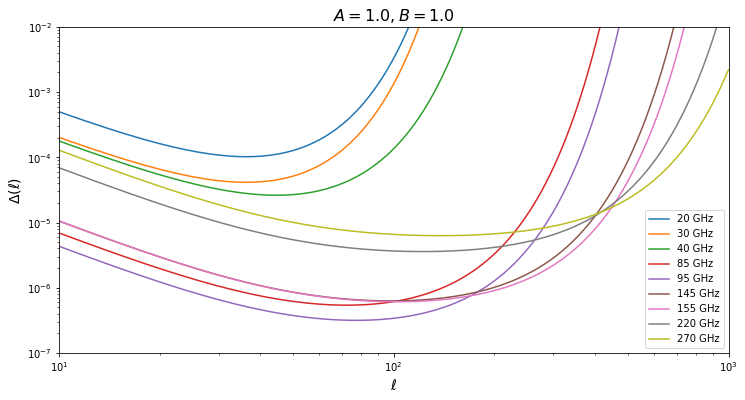

In [14]:
# S4 noise parameters
l = np.arange(10, 1000)
nu = [20, 30, 40, 85, 95, 145, 155, 220, 270]
N_BB = np.array([1.83e-5, 7.41e-6, 6.67e-6, 2.65e-7, 1.66e-7, 4.06e-7, 4.06e-7, 2.66e-6, 4.95e-6])
sigma = np.array([2.23e-2, 2.23e-2, 1.67e-2, 7.85e-3, 7.04e-3, 4.63e-3, 4.31e-3, 3.11e-3, 2.47e-3])
# Make plot
plt.figure(figsize=(12, 6))
A = 1.0
B = 1.0
for i in range(len(N_BB)):
    Delta = N_BB[i] * (A + B * (l / 50.0)**(-2.0)) * np.exp(l**2 * sigma[i]**2)
    plt.plot(l, Delta, label="{} GHz".format(nu[i]))
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 1000)
plt.ylim(1e-7, 1e-2)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel('$\Delta (\ell)$', fontsize=14)
plt.legend(loc='lower right')
plt.title('$A = {}, B = {}$'.format(A, B), fontsize=16)

After defining $\Delta(\ell)$ for all auto-spectra, we need to calculate the bias on each bandpower. Do this using the bandpower window functions, $f_{ij} (\ell)$, for auto-spectrum $i$ and bin $b$. Our bandpower window functions are defined for $\ell (\ell + 1) C_\ell / 2 \pi$, so put those factors in.

$$
\begin{equation}
\Delta_{ib} (A,B) = \frac{\sum_\ell \frac{\ell (\ell + 1)}{2 \pi} \Delta_i (\ell, A, B) \; f_{ib} (\ell)}{\sum_\ell f_{ib} (\ell)}
\end{equation}
$$

Finally, we can use the estimator weights to calculate the bias on $r$ due to $\Delta_{ib}$. Our upper limit for the bias is 1e-4. If we allow half of that bias to come from the white part and half from the $1/\ell$ part, then we want to select $A, B$ such that:

$$
\begin{align}
\Delta r (A, B=0) &= 0.5e-4 \\
\Delta r (A=0, B) &= 0.5e-4
\end{align}
$$

## 2. Correlated systematic

This version of the systematic is correlated across all frequencies and affects the cross-spectra as well as auto-spectra. While the uncorrelated systematic has amplitude that scales according to the noise level in each auto-spectrum, we define the correlated systematic to have the same amplitude across all frequencies (in units of $\mu K_{CMB}$) so that it looks like a CMB signal. However, we will still use a functional form that has one component that is white in the observed map and another component that scales as $1/\ell$ in the observed map.

<strong style="color: red;">Question 3: Do we want this "CMB-like" behavior for the correlated systematic, or would we rather have a systematic like Section 1 except also affecting cross-spectra?</strong>

To define "units of noise" for the correlated systematic, I will use the $N_{raw}$ construction that Victor introduced in [this posting](http://bicep.rc.fas.harvard.edu/CMB-S4/analysis_logbook/20170525_s4syst/), except that I'm just going to evaluate it for the white noise $N^{BB}$.

$$
\begin{equation}
N_{comb} = \left[ \sum_i (N_i^{BB})^{-2} \right]^{-1/2}
\end{equation}
$$

To three significant digits, we get the same value whether or not we include the 20 GHz channel: 1.26e-7 $\mu K^2$

In [17]:
print 1.0 / np.sqrt((N_BB**(-2.0)).sum())     # includes 20 GHz
print 1.0 / np.sqrt((N_BB[1:]**(-2.0)).sum()) # excludes 20 GHz

1.26099523789e-07
1.26102517595e-07


With this combined noise level, we then define the bias as a function of $\ell$ very similar to Section 1 except that it is also defined for cross-spectra between frequency channels $i$ and $j$.

$$
\begin{equation}
\Delta_{ij} (\ell) = N_{comb} \left[ A + B \left( \frac{\ell}{50} \right)^{-2} \right] \exp \left( \ell^2 \sigma_i \sigma_j \right)
\end{equation}
$$

Note that the "CMB-like" behavior (i.e. bias is the same at all frequencies) gets broken by the beam window functions, which are different for each auto or cross-spectrum. This is mostly relevant for higher $\ell$ bins that don't contribute strongly to the $r$ constraint, but it might have some effect.

<strong style="color: red;">Question 4: Do we want this behavior? Or should we apply some beam correction that is the same at all frequencies, perhaps using the 145 GHz beamsize?</strong>

As in Section 1, we use the bandpower window functions to calculate bandpower bias from $\Delta_{ij} (\ell)$, then use the estimator weights to find the values of $A$ and $B$ such that the white and $1/\ell$ components each contribute bias equivalent to $r = 0.5e-4$.